(This notebook is a companion piece to a lecture on radio astronomy basics for software developers. It can be found in GitHub at https://github.com/juandesant/image-fft-calculations.)

# Image calculations with FFTs and operations

We start by preparing the environment. We will use NumPy, Matplotlib, and the Python Imaging Library (PIL) for the different manipulations.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

We setup the figure size quite big to make the most impact

In [2]:
plt.rcParams['figure.figsize'] = [30, 15]

## Reading images and doing FFTs

In order to load an image, we need to combine `Image.open` with the `ImageOps.grayscale` operations, together with NumPy's `np.array` converstion.

![Inverted image of the Pisa Tower, with white background](PisaTower-Image-Presentation.png)

Please note the usage of `as_gray`=True to make sure that we are getting a single luminance channel of the image for processing. For grayscale images that is not requried, but it helps making sure we are doing the right operations.

_(Previous version of this notebook used Scikit-Image for the image reading and showing; by removing that dependency, this notebook can be used in platforms that can install the PIL as a pure Python module)_

We need to define a normalisation function that will help us with reading the image data representing the FFT, in case the dynamic range is small. The function maps linearly values from `array_min` to `scale_min`, and from `array_max` to `scale_max`, interpolating linearly among them.

In [3]:
def normalise(vector, scale_min=0, scale_max=255):
    array_min, array_max = np.min(vector), np.max(vector)
    array_range = array_max-array_min
    return ((vector-array_min)/array_range*(scale_max-scale_min)+scale_min)

We will also define some helper functions (similar to those available in `skimage.io`, but without depending on them) for `imread`, `imshow`, and `imsave`.

In [4]:
# This helper functions can be removed if you use Scikit-Image (import skimage)
def imread(path, as_gray=False):
    image = Image.open(path)
    if as_gray:
        return np.array(ImageOps.grayscale(image))
    else:
        return np.array(image)

def imshow(source, **kwargs):
    plt.imshow(source, **kwargs)

def imsave(path, image_data, invert=False):
    if type(image_data) == np.ndarray:
        image_data = Image.fromarray(normalise(image_data).astype(np.uint8))
    if invert:
        image_data = ImageOps.invert(image_data)
    image_data.save(path)

We read now the 'PisaTower-Image-Presentation.png' image into `pisa_tower`. Note that if we don't use `as_gray`, we will load the image (even if the original data is one channel) as RGBA (red, gree, blue, alpha) multidimensional array. 

In [5]:
pisa_tower = imread('PisaTower-Image-Presentation.png', as_gray=True)

We proceed to show it now…

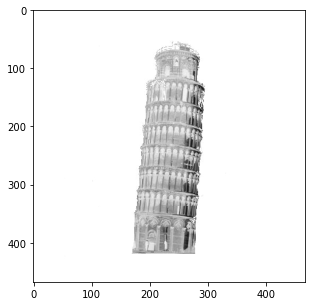

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
imshow(pisa_tower, cmap='gray')

We then use `np.fft.fft2` and `np.fft.ifft2` to perform the 2D Fast Fourier Transform. Bear in mind that NumPy FFT returns the (0,0) spatial frequency coefficient in the top-left corner (so that it can be indexed at `[0,0]`. The `np.fft.fftshift` takes care of shifting the FFT so that lower frequencies are in the center of the matrix, and lower coefficients to the sides.

In [7]:
pisa_tower_fft = np.fft.fftshift(np.fft.fft2(pisa_tower)) # FFT 
pisa_tower_ifft = np.abs(np.fft.ifft2(np.fft.fftshift(pisa_tower_fft))) # Inverse FFT

We can now proceed to show the Pisa Tower image reconstructed from its inverse FFT (in `pisa_tower_ifft`), and the FFT itself side by side. Note the use of the `'Greys'` colour map to make more intense parts of the FFT represented by darker colours, and of `np.log` to apply a logarithmic scale. If we did not do that, it would be difficult to see details in the resulting FFT.

To show them side by side, we use the `matplotlib.pyplot` module (named `plt` in the import above) to create 1 row of 2 subplots. As there is only one row, the returned array of axes (`axarr`) is unidimensional. We can then use `imshow` with each of them. The use of `'gray_r'` inverts the colormap, without inverting the image.

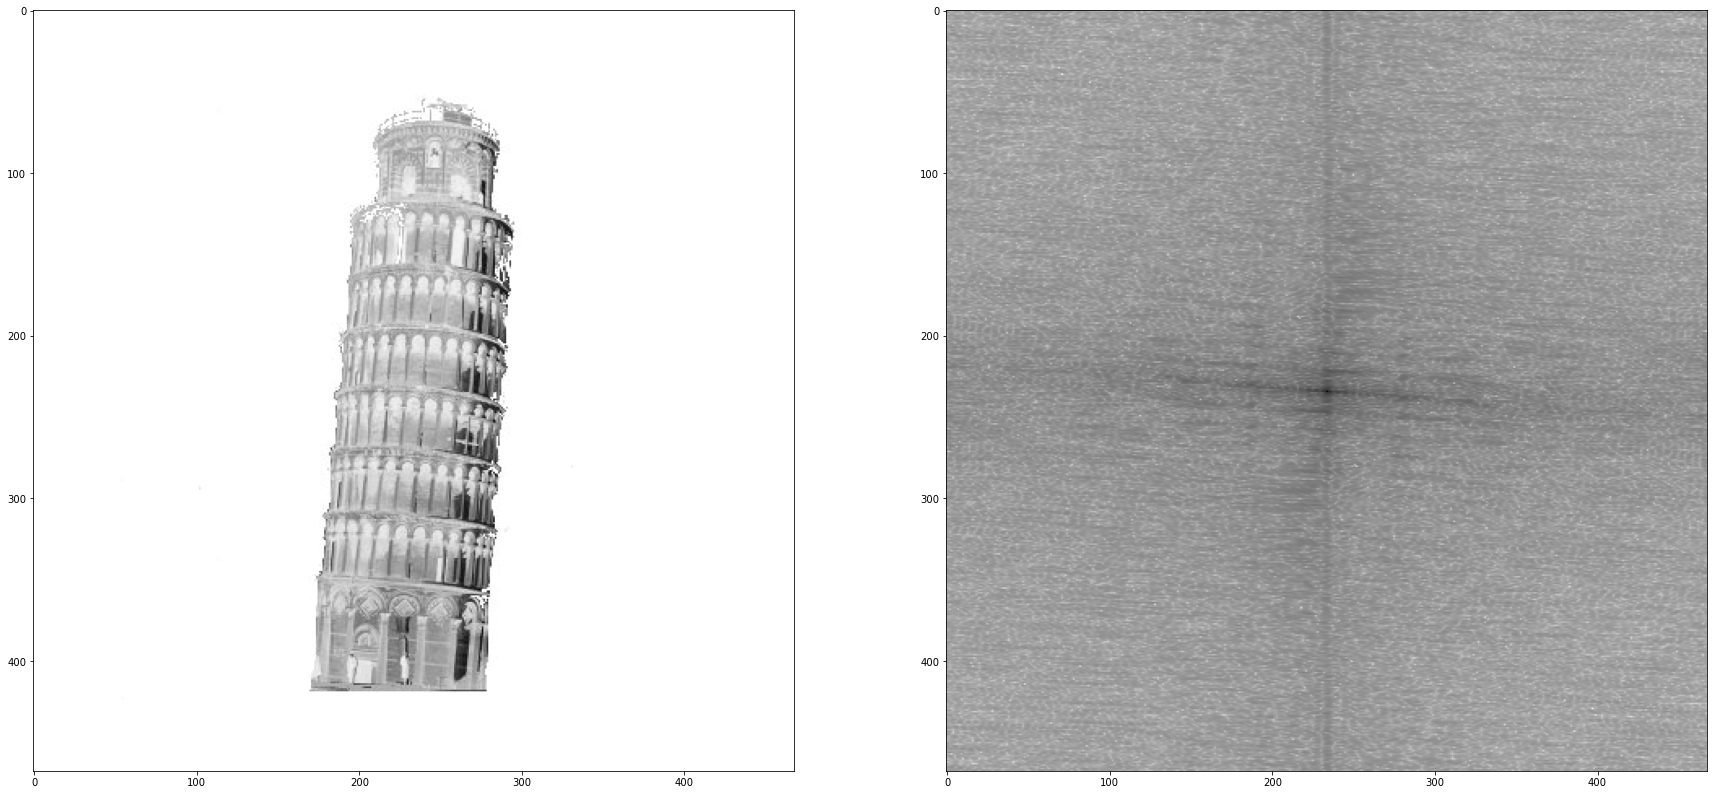

In [8]:
plt.rcParams['figure.figsize'] = [30, 15]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(pisa_tower_ifft, cmap='gray')
axarr[1].imshow(np.log(np.abs(pisa_tower_fft)), cmap='gray_r')

We now save the image of the FFT with `imsave` (again, imported from Scikit-Image), so that we can make use of it in other publications, or loaded again with `imload`. Note the use of `invert=True` to make sure that the image is saved with inverted scale.

In [9]:
imsave('pisa-tower-fft.png', np.log(np.abs(pisa_tower_fft)), invert=True)

## Combining images with FFT operations

We are going to perform a couple of operations to show the relative importance of amplitude and phase in the Fourier domain. We start by reading a couple of images from Chancellor Merkel and former President Obama into `chancellor` and `president`, respectively. Again, notice the usage of the `as_gray` parameter.

In [10]:
chancellor = imread('Merkel-Image-Presentation.png', as_gray=True)
president = imread('Obama-Image-Presentation.png', as_gray=True)

/private/var/containers/Bundle/Application/90A4C49D-9F2F-4375-91ED-1370968F388B/Carnets.app/Library/lib/python3.9/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


For single images we change the figure size to make it smaller.

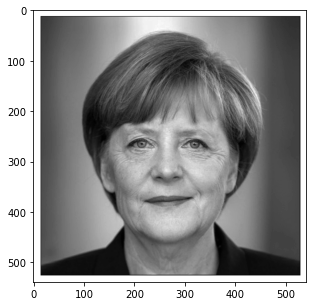

In [11]:
plt.rcParams['figure.figsize'] = [5, 5]
imshow(chancellor, cmap='gray')


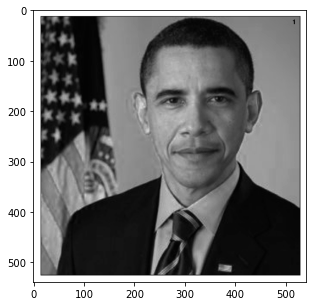

In [12]:
plt.rcParams['figure.figsize'] = [5, 5]
imshow(president, cmap='gray')

To show both images side by side, we resize again the target figure size, and create two subplots. Remember that `f` represents the figures, and `axarr` the axes.

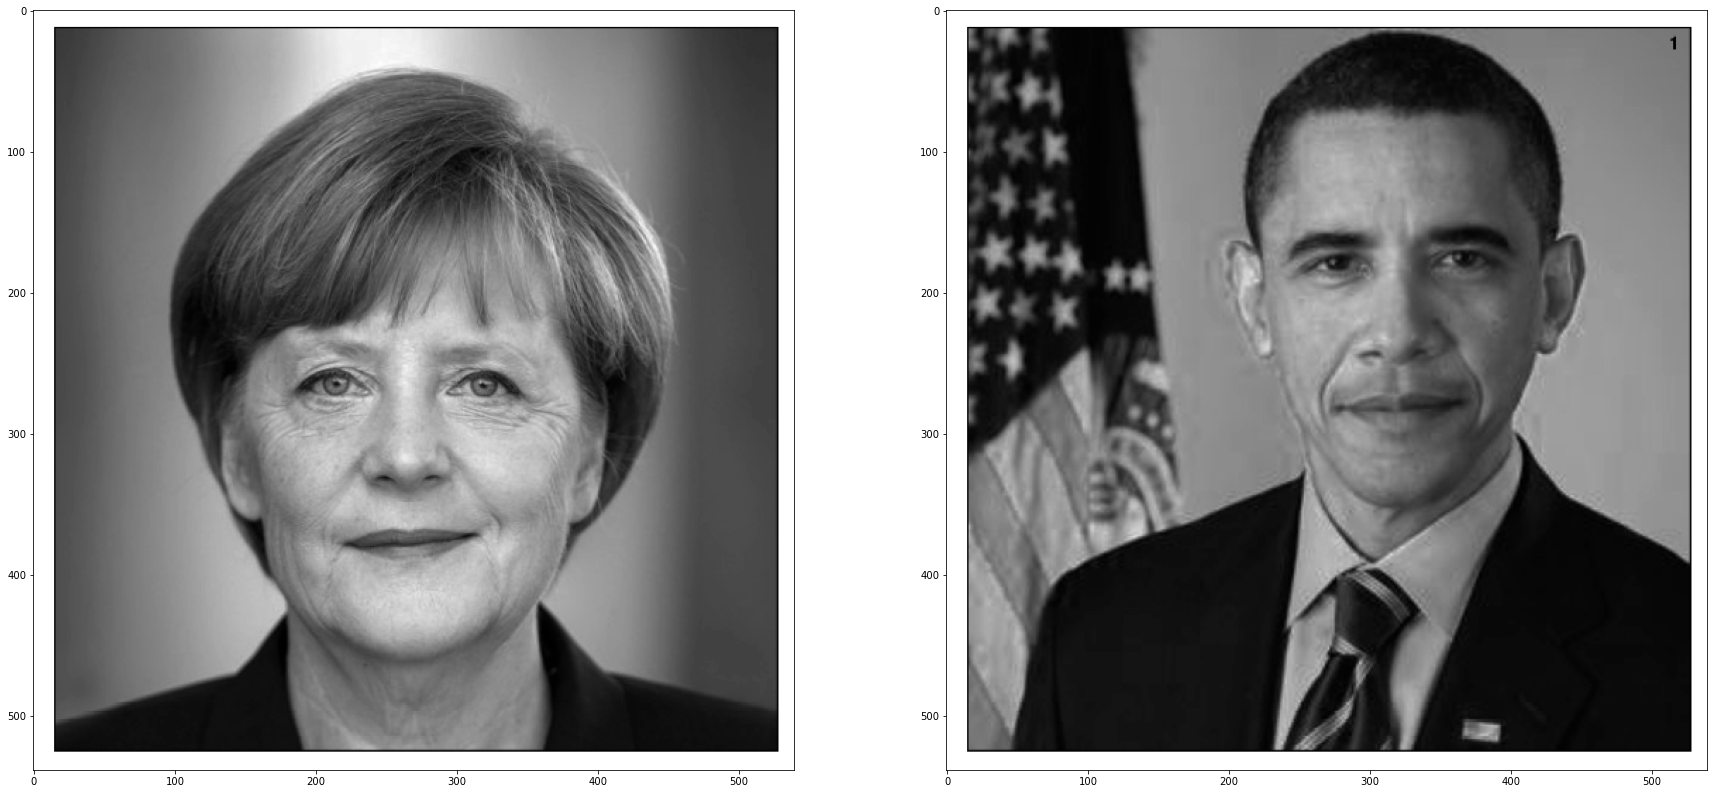

In [13]:
plt.rcParams['figure.figsize'] = [30, 15]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(chancellor, cmap='gray')
axarr[1].imshow(president, cmap='gray')

### Mixing Amplitude and Phase

We will demonstrate what happens if we mix the phase of one image with the amplitude from another. First, we calculate amplitude and phase for both images, from their Fourier transform. `np.abs` gives us the amplitude of a complex number, and `np.angle` its phase. When applied to matrices (`np.array`s), they are individually applied to each element.

In [14]:
chancellor_fft   = np.fft.fftshift(np.fft.fft2(chancellor))
president_fft    = np.fft.fftshift(np.fft.fft2(president))
chancellor_amp   = np.abs(chancellor_fft)
chancellor_phase = np.angle(chancellor_fft)
president_amp    = np.abs(president_fft)
president_phase  = np.angle(president_fft)

Remember that a complex number $C$ can be written as the multiplication of its amplitude $A$ by the complex exponential of the phase $\phi$ (also known as argument, or angle):

$$ C = A \, exp(i \phi) $$

Remember as well that:

$$exp(i \phi) = cos(\phi) + i sin(\phi)$$

Given that, to mix the amplitude of the President image `president_amp` with the phase of the Chancellor image `chancellor_phase` (both real matrices), we need to: 
 1. create a complex number from the multiplication of the amplitude by the complex exponential of the phase (`president_amp*np.exp(1j*chancellor_phase)`)
 2. perform the inverse FFT of that with `np.fft.ifft2`
 3. obtain the absolute value of the complex number (the imaginary part of the image should be zero, but `imsave` or `imshow` might be confused if we don't remove it)
 
As we had used `np.fft.fftshift` for `chancellor_fft` and `president_fft`, we need to use it again before we perform the inverse FFT.

In [15]:
recovered_chancellor = np.abs(
    np.fft.ifft2(
        np.fft.fftshift(
            president_amp*np.exp(1j*chancellor_phase)
        )
    )
)

And we proceed to save it.

In [16]:
imsave('chancellor-phase-president-amp.png', np.abs(recovered_chancellor))

We do now the same steps but now using `chancellor_amp` for the amplitude, and `president_phase` for the phase.

In [17]:
recovered_president = np.abs(
    np.fft.ifft2(
        np.fft.fftshift(
            chancellor_amp*np.exp(1j*president_phase)
        )
    )
)

In [18]:
imsave('president-phase-chancellor-amp.png', np.abs(recovered_president))

And we show the reconstucted images side by side.

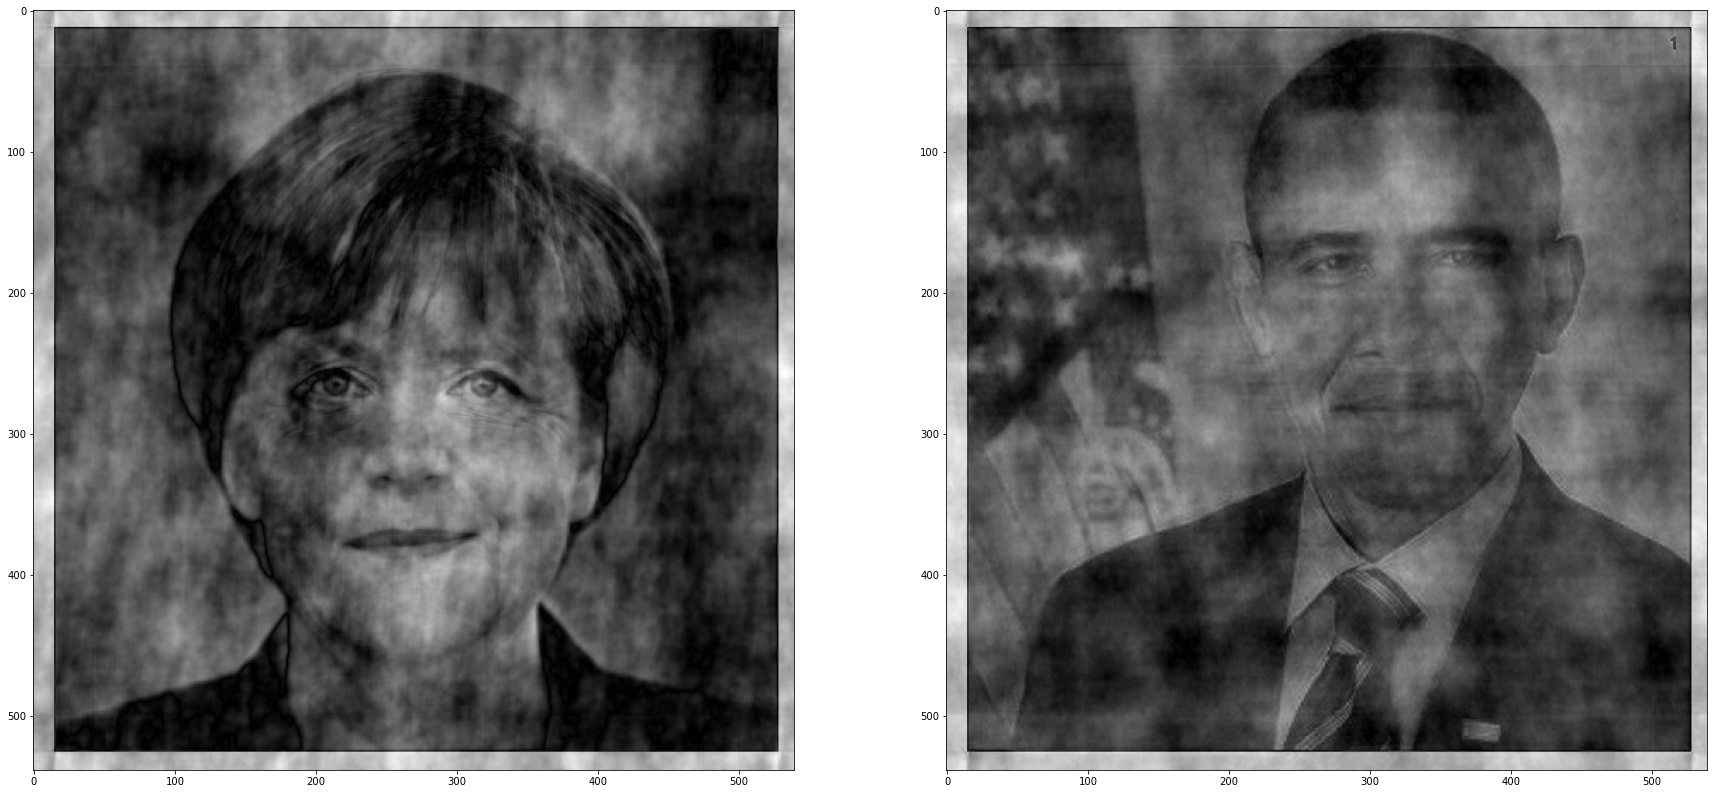

In [19]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(recovered_chancellor, cmap='gray')
axarr[1].imshow(recovered_president,  cmap='gray')

### Removing phase or amplitude information

Another way of showing the relative importance of amplitude versus phase is completely removing one of those bits of information, and see what can be recovered. We will use the following dutch mill image for that:

![Dutch mill with uniform background](DutchMill-Image-Presentation.jpeg)

We use `imread` (with the `as_gray=True` parameter) to get it into the `dutch_mill` 2D matrix.

In [20]:
dutch_mill = imread('DutchMill-Image-Presentation.jpeg', as_gray=True)

Then, we perform the 2D FFT using `np.fft.fft2` and `np.fft.fftshift` in succession.

In [21]:
dutch_mill_fft = np.fft.fftshift(np.fft.fft2(dutch_mill))

We will show now both the image and the centred 2D FFT side by side.

Please note that in this case we are not using `util.invert`, and hence the brightest pixels corresponds to elements in the FFT with the highest values. Note the high level of continuum, and the repeating patterns and harmonics, which can be shown thanks to the use of a logarithmic scale (`np.log`).

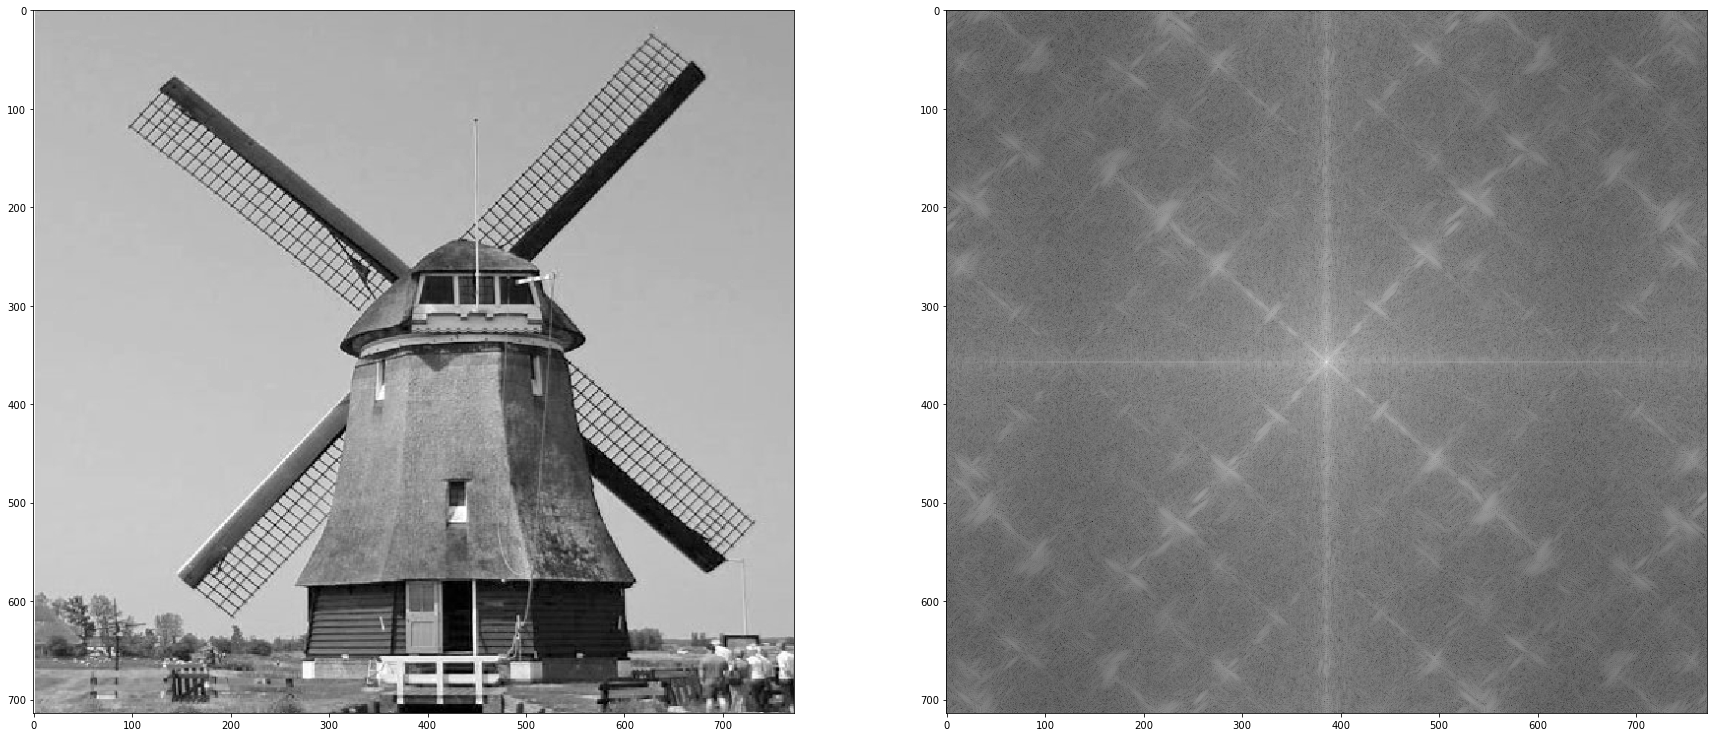

In [22]:
plt.rcParams['figure.figsize'] = [30, 15]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.abs(dutch_mill), cmap='gray')
axarr[1].imshow(np.abs(np.log(np.abs(dutch_mill_fft))), cmap='gray')

Let's show that we can recover partially the mill if we fix the amplitude to one (again, notice the use of `normalise` to increase the dynamic range; the `imsave` step cannot work without it).

In [23]:
unit_amp_dutch_mill_fft = 1*np.exp(1j*np.angle(dutch_mill_fft))
recovered_dutch_mill = np.fft.ifft2(
    np.fft.fftshift(unit_amp_dutch_mill_fft)
)
recovered_unit_amp_dutch_mill = normalise(np.abs(recovered_dutch_mill))


In [24]:
imsave('dutch-mill-unit-amp.png', recovered_unit_amp_dutch_mill, invert=True)

Now, if to preserve the amplitude, but zeroing the phase, we calculate the absolute value and add `0j` to make it complex. Again, we need to normalise the result in order to be able to use `imsave`.

In [25]:
zero_phase_dutch_mill_fft = np.abs(dutch_mill_fft)+0j
recovered_dutch_mill_zero_phase = np.fft.ifft2(
    np.fft.fftshift(zero_phase_dutch_mill_fft)
)
recovered_zero_phase_mill_log = normalise(np.log(np.abs(recovered_dutch_mill_zero_phase)))

In [26]:
imsave('zero-phase-recovered-dutch-mill.png', recovered_zero_phase_mill_log, invert=True)

Finally, we can show the images side by side.

Text(0.5, 1.0, 'Recovered image with zero phase')

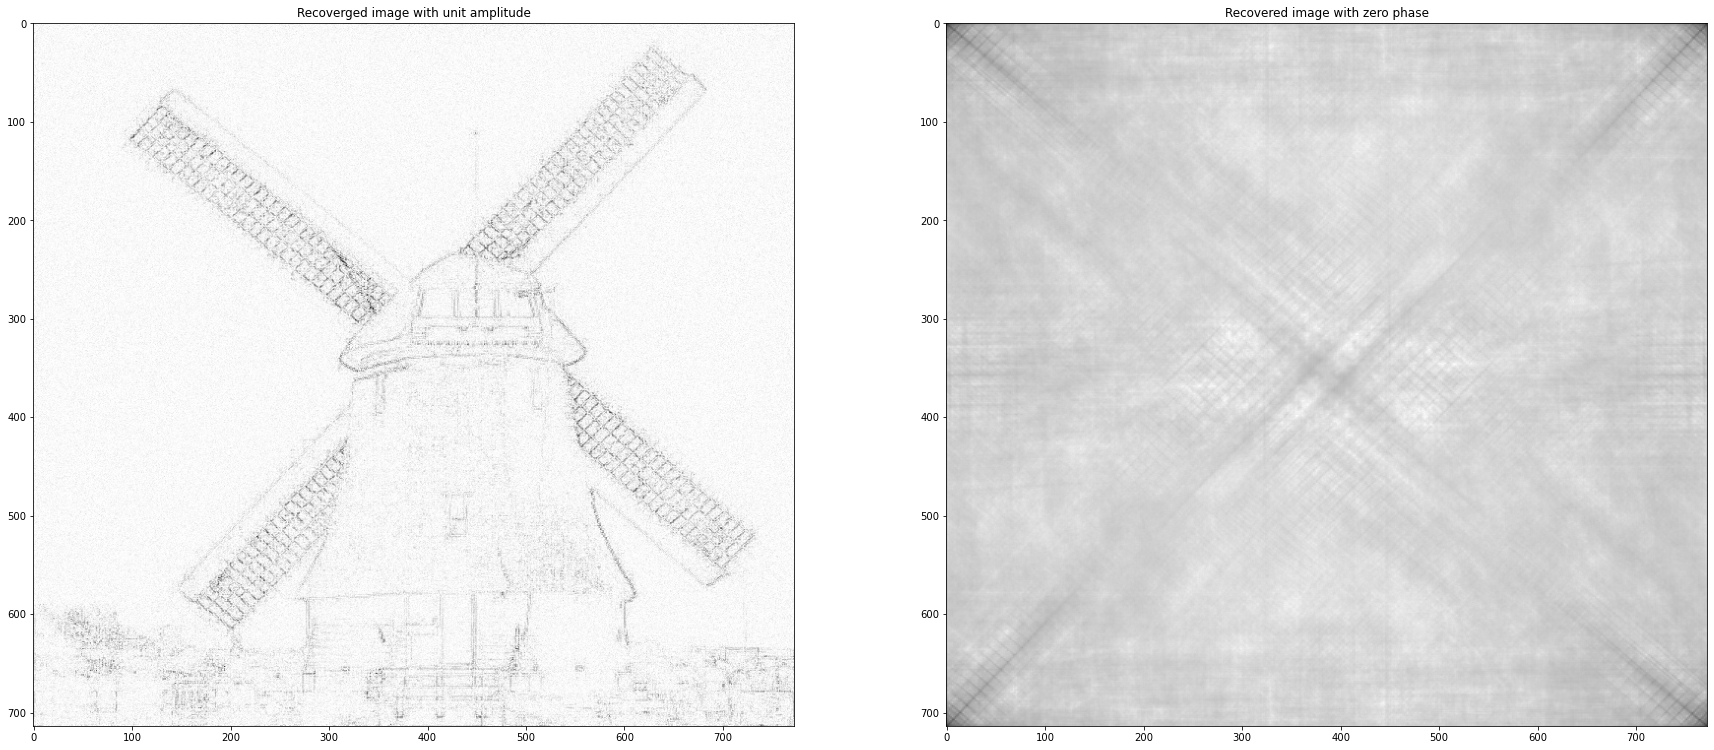

In [27]:
plt.rcParams['figure.figsize'] = [30, 15]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(recovered_unit_amp_dutch_mill, cmap='gray_r')
axarr[0].set_title("Recoverged image with unit amplitude")
axarr[1].imshow(recovered_zero_phase_mill_log, cmap='gray_r')
axarr[1].set_title("Recovered image with zero phase")


## Sampling FFT and quality of recovered image

Lastly, let's show how we can create several sampling matrices to apply to the FFT of the Pisa Tower, and how recognisable is what we can recover from them.

We start by setting `target_fft` to `pisa_tower_fft`, but can be set to any FFT matrix to be sampled (i.e., `chancellor_fft`).

Then, we get the image dimensions in `sampling_dimensions`; we create a matrix called `sampling_coordinates` which gives tuples of coordinates for each matrix element; and we create list called num_samples_iterations that calculates how many samples must include each sampling matrix for a set percentage (from 0.1% to 100%, in arbitrary steps).

In [28]:
target_fft = pisa_tower_fft
sampling_dimensions = np.shape(target_fft)
sampling_coordinates = [
    (x,y)
    for x in range(0,sampling_dimensions[0])
    for y in range(0,sampling_dimensions[1])
]

num_samples_iterations = [
    min(int(target_fft.size*x/100)+1, target_fft.size)
    for x in [0.1, 1,5,10,25,50,75,80,90,99, 99.9,100] # percentages of samples to showcase
]
num_samples_iterations

[220,
 2191,
 10952,
 21903,
 54757,
 109513,
 164269,
 175220,
 197122,
 216834,
 218805,
 219024]

Now that we know how many samples to take, we create a list of the coordinates to be actually sampled for each percetage, selected as random. For each of the numbers of samples in `num_samples_iterations`, we:
 1. use `np.random_choice` to create a list of tuples of the intented num of samples lenghts. The `replace=False` argument makes sure that no coordinate is repeated, ensuring that the coordinates are distinct. 
 2. then, we append a sampling matrix with zeros in values not to be sampled, and 1 in the coordinates that we intend to sample

In [29]:
sampling_arrays = []
for i in range(0,len(num_samples_iterations)):
    index_pairs = [
        sampling_coordinates[x]
        for x in np.random.choice(range(0,len(sampling_coordinates)), size=num_samples_iterations[i], replace=False)
    ]
    sampling_arrays.append(np.zeros(sampling_dimensions,))
    for j in range(0,len(index_pairs)):
        sampling_arrays[i][index_pairs[j]]=1

Now, we want to create a list of recovered images with each of the sampling matrices. Each `i`th element is the absolute value (`np.abs`) of the inverse 2D FFT (`np.fft.ifft2`) of the sampled FFT (`target_fft*sampling_arrays[i]`).

In [30]:
recovered_image_from_sampling = [
    np.abs(np.fft.ifft2(target_fft*sampling_arrays[i]))
    for i in range(0,len(sampling_arrays))
]

We can now show each sampling matrix side by side with the reconstructed image. We make the figure larger to accommodate all of the subplots. Notice how we set the title so that we can see what percentage of samples are being taken into account. Dark dots indicate where samples are being evaluated, and for 100% you can see that the sampling matrix is all black. 

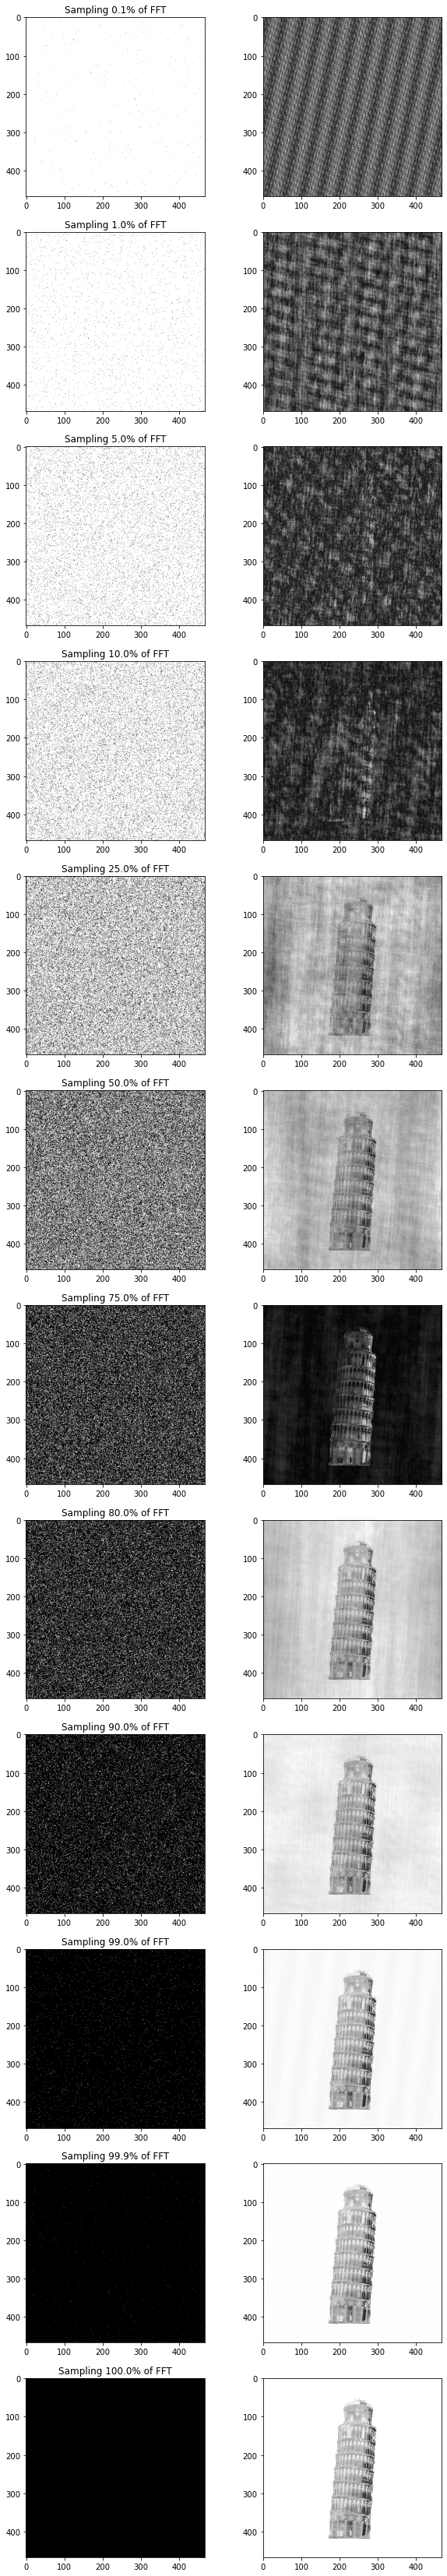

In [31]:
plt.rcParams['figure.figsize'] = [10, 60]
f, axarr = plt.subplots(len(sampling_arrays),2)
for i in range(0, len(sampling_arrays)):
    axarr[i][0].imshow(sampling_arrays[i], vmin=0.0, vmax=1.0, cmap='gray_r')
    axarr[i][0].set_title(f"Sampling {num_samples_iterations[i]*100/target_fft.size:2.1f}% of FFT")
    #axarr[i][1].set_title(f"Reconstructed image from FFT with {num_samples_iterations[i]:d} samples")
    axarr[i][1].imshow(recovered_image_from_sampling[i], cmap='gray')

You can see that when the central pixel of the FFT is not sampled, the average reconstruction becomes null. Also notice how even at 99% of sampling, the background is still not fully white.